In [1]:
import pandas as pd
data = pd.read_csv("./data/kaggle/train.csv")
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [2]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

<AxesSubplot:>

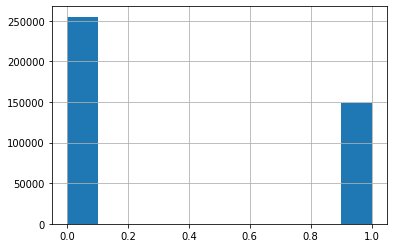

In [4]:
data.is_duplicate.hist()

In [26]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from collections import Counter
from nltk.corpus import stopwords

In [9]:
RANDOM_SEED = 28091997
ROUNDS = 200

def train_xgb(X, y, params):
    print("Will train XGB for {} rounds, Random Seed: {}".format(ROUNDS, RANDOM_SEED))
    x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = RANDOM_SEED)
    xg_train = lgb.Dataset(x, label=y_train)
    xg_val = lgb.Dataset(X_val, label=y_val)
    watchlist = [xg_val]
    clf = lgb.train(params, xg_train, ROUNDS, watchlist)
    return clf

In [10]:
def predict_xgb(clr, X_test):
    return clr.predict(X_test)

In [11]:
def add_word_count(x, df, word):
    x['q1_' + word] = df['question1'].apply(lambda x: (word in str(x).lower()*1))
    x['q2_' + word] = df['question2'].apply(lambda x: (word in str(x).lower()*1))
    x[word + '_both'] = x['q1_' + word] * x['q2_' + word]

In [12]:
param = {}
param['learning_rate'] = 0.14
param['boosting_type'] = 'dart'
param['objective'] = 'binary'
param['metric'] = 'binary_logloss'
param['sub_feature'] = 0.5
param['num_leaves'] = 512
param['min_data'] = 50
param['min_hessian'] = 1

In [13]:
data.shape

(404290, 6)

In [14]:
# Nếu một từ chỉ xuất hiện một lần, chúng tôi sẽ bỏ qua nó hoàn toàn (có thể là lỗi đánh máy)
# Epsilon xác định một hằng số làm mịn, làm cho hiệu ứng của các từ cực kỳ hiếm trở nên nhỏ hơn
def get_weight(count, eps=10000, min_count=2):
    return 0 if count < min_count else 1/(count + eps)

In [15]:
train_qs = pd.Series(data['question1'].tolist() + data['question2'].tolist()).astype(str)

In [16]:
train_qs

0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
808575    How many keywords are there in PERL Programmin...
808576           Is it true that there is life after death?
808577                                    What's this coin?
808578    I am having little hairfall problem but I want...
808579        What is it like to have sex with your cousin?
Length: 808580, dtype: object

In [17]:
words = (" ".join(train_qs)).lower().split()

In [19]:
len(words)

8944593

In [21]:
count = Counter(words) # Gán ID cho từng từ

In [24]:
weights = {word: get_weight(count) for word, count in count.items()} # Tương đương việc tính TF

In [28]:
stops = set(stopwords.words("english"))

In [30]:
len(stops)

179

In [34]:
def word_shares(row):
    q1_list = str(row['question1']).lower().split()
    q1 = set(q1_list)
    q1words = q1.difference(stops)
    if len(q1words) == 0:
        return '0:0:0:0:0:0:0:0'
    
    q2_list = str(row['question2']).lower().split()
    q2 = set(q2_list)
    q2words = q2.difference(stops)
    if len(q2words) == 0:
        return '0:0:0:0:0:0:0:0'

    words_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1])/max(len(q1_list), len(q2_list))

    q1stops = q1.intersection(stops)
    q2stops = q2.intersection(stops)

    q1_2gram = set([i for i in zip(q1_list, q1_list[1:])])
    q2_2gram = set([i for i in zip(q2_list, q2_list[1:])])

    shared_2gram = q1_2gram.intersection(q2_2gram)

    shared_words = q1words.intersection(q2words)
    shared_weights = [weights.get(w, 0) for w in shared_words]
    q1_weights = [weights.get(w, 0) for w in q1words]
    q2_weights = [weights.get(w, 0) for w in q2words]
    total_weights = q1_weights + q1_weights
    
    R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    R2 = len(shared_words) / (len(q1words) + len(q2words) - len(shared_words)) #count share
    R31 = len(q1stops) / len(q1words) #stops in q1
    R32 = len(q2stops) / len(q2words) #stops in q2
    Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
    Rcosine = np.dot(shared_weights, shared_weights)/Rcosine_denominator
    if len(q1_2gram) + len(q2_2gram) == 0:
        R2gram = 0
    else:
        R2gram = len(shared_2gram) / (len(q1_2gram) + len(q2_2gram))
    return '{}:{}:{}:{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32, R2gram, Rcosine, words_hamming)

In [35]:
df_train = data
df_test = pd.read_csv("./data/kaggle/test.csv")
df = pd.concat([df_train, df_test])
df['word_shares'] = df.apply(word_shares, axis=1, raw=True)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
df